In [52]:
#-----------------------------------------------General packages-----------------------------------------------------
%matplotlib notebook

import os # operating system package: giving the path, reading the files from different directories etc
from glob import glob
import joblib # for saving the models


# pandas and numpy are among the most popular python packages for working with data.
# numpy is used for image processing to deal with multidimensional dataset
import numpy as np
import numba
from numba import jit
import pandas as pd
import random
import datetime
import psutil
from itertools import chain
from scipy.ndimage.measurements import label
from scipy.ndimage import find_objects
import scipy.ndimage as spim
##This package contains various functions for multi-dimensional image processing.
# it includes different filters, measurememts functions


from collections import namedtuple
from porespy.tools import extend_slice
from PIL import Image
#------------------------------------ matplotlib is amain python package for plotting 
import matplotlib .pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn as sns

##---------------------------------------packages for image preprocessing (filtering)-------------------------------------

import skimage
from skimage import io # module providing different utilities to read, wrrite images
import tifffile
from skimage import img_as_ubyte

# from skimage import data, img_as_float
from skimage.transform import resize


from skimage.metrics import peak_signal_noise_ratio, mean_squared_error, structural_similarity
# from similaritymeasures import frechet_dist


from functools import partial

from tqdm import tqdm # for showing the progress bar during a loop

## for cropping images
import scipy
from scipy import ndimage



from skimage.filters import threshold_otsu
# from scipy.ndimage.filters import median_filter

# from dataset import HDF5Dataset
# from hdf5_io import save_hdf5
# import h5py
import pickle

#pytorch library
# import torch
# from torch import nn
# from tqdm.auto import tqdm
# import torchvision
# from torchvision import transforms
# from torchvision.utils import make_grid
# from torch.utils.data import DataLoader, Dataset
# from torchvision.datasets import ImageFolder

# from torch.utils.data.dataloader import DataLoader


#Ivan's library

# %% import libs
import sys
import subprocess
import shutil
from PIL import Image
# set the random seed to generate same random torch tensor and random number each time
# torch.manual_seed(43)
random.seed(43)

In [34]:
@jit 
# --> It is preferred to use numba here for a speed-up, if installed!!
def two_point_correlation(im, dim, var=0):
    """
    This method computes the two point correlation,
    also known as second order moment,
    for a segmented binary image in the three principal directions.
    
    dim = 0: x-direction
    dim = 1: y-direction

    """
    if dim == 0: #x_direction
        dim_1 = im.shape[1] #y-axis
        dim_2 = im.shape[0] #x-axis
    elif dim == 1: #y-direction
        dim_1 = im.shape[0] #x-axis
        dim_2 = im.shape[1] #z-axis
        
    two_point = np.zeros((dim_1, dim_2))
    for n1 in range(dim_1):
        for r in range(dim_2):
            lmax = dim_2-r
            for a in range(lmax):
                if dim == 0:
                    pixel1 = im[a, n1]
                    pixel2 = im[a+r, n1]
                elif dim == 1:
                    pixel1 = im[n1, a]
                    pixel2 = im[n1, a+r]

                if pixel1 == var and pixel2 == var:
                    two_point[n1, r] += 1
            two_point[n1, r] = two_point[n1, r]/(float(lmax))
    return two_point

In [35]:
def calculate_smd_list(images):
    """This function calculate s2 for a stack of images and return a list of correlations s2 and scaled autocovariance
    The list contains correaltions of all the slices"""
    fn_list = []
    s2_list = []
#     Nr_list = []
    if len(images.shape) == 3: # if you read slices in a one stack of numpy array
        
        for i in tqdm(range(images.shape[0])):
            two_pt_dim0 = two_point_correlation(images[i], dim = 0, var = 1) #S2 in x-direction
            two_pt_dim1 = two_point_correlation(images[i], dim = 1, var = 1) #S2 in y-direction

            #Take average of directions; use half linear size assuming equal dimension sizes
            Nr = two_pt_dim0.shape[0]//2

            S2_x = np.average(two_pt_dim1, axis=0)[:Nr]
            S2_y = np.average(two_pt_dim0, axis=0)[:Nr]
            S2_average = ((S2_x + S2_y)/2)[:Nr]

            s2_list.append(S2_average)

            # autoscaled covriance---------------------------------------
            f_average = (S2_average - S2_average[0]**2)/S2_average[0]/(1 - S2_average[0])
            fn_list.append(f_average)
            
             # N(L) number of different size lines
#             Nr_list.append(Nr)
        return s2_list, fn_list,Nr_list
    
    elif len(images.shape) == 2: # in case we only have a 2D image, don't need to return a list 

        two_pt_dim0 = two_point_correlation(images, dim = 0, var = 1) #S2 in x-direction
        two_pt_dim1 = two_point_correlation(images, dim = 1, var = 1) #S2 in y-direction

        #Take average of directions; use half linear size assuming equal dimension sizes
        Nr = two_pt_dim0.shape[0]//2

        S2_x = np.average(two_pt_dim1, axis=0)[:Nr]
        S2_y = np.average(two_pt_dim0, axis=0)[:Nr]
        S2_average = ((S2_x + S2_y)/2)[:Nr]

        s2_list.append(S2_average)

        # autoscaled covriance---------------------------------------
        f_average = (S2_average - S2_average[0]**2)/S2_average[0]/(1 - S2_average[0])
        fn_list.append(f_average)
        
        # N(L) number of different size lines
        Nr_list.append(Nr)
        return S2_average, f_average,Nr_list

In [36]:
class Microstructure:
    # init method
    def __init__(self, dims, ns):
        

        self.dims = dims  # number of dimensions (2 or 3)
        self.ns = ns  # number of samples per dimensions - all dims must have equal number of samples

        if dims == 2:  # 2D sample
            self.structure = np.ones((ns, ns))  # stores two-phase (binary) sampled microstructure
            self.sourceimage = np.ones((ns, ns))  # stores source image for self.structure
        elif dims == 3:  # 3D sample
            self.structure = np.ones((ns, ns, ns))
            self.sourceimage = np.ones((ns, ns, ns))
        else:  # only 2D or 3D are allowed
            raise Exception('Number of dimensions must be 2 or 3.')

    # Miscellanous class vars
    name = 'default_sample'  # sample name

    # dims = int(2)
    # ns = int(251)
    # structure = np.ones((ns, ns))
    # sourceimage = np.ones((ns, ns))

    def description(self):
        if self.dims == 2:
            desc_str = "Sample %s is a %dD microstructure with %d x %d pixels." % (
                self.name, self.dims, self.ns, self.ns)
        else:
            desc_str = "Sample %s is a %dD microstructure with %d x %d x %d pixels." % (
                self.name, self.dims, self.ns, self.ns, self.ns)
        return desc_str

    def volumefraction(self):
        self.ninclusion = 0  # number of inclusion/black pixels, assume black pixels have 0 value
        structure = self.structure
        # count inclusion pixels
        if self.dims == 2:
            for ix in range(self.ns):
                for iy in range(self.ns):
                    if structure[ix, iy] == 1: # pore =1, solid = 0
                        self.ninclusion += 1
        elif self.dims == 3:
            for ix in range(self.ns):
                for iy in range(self.ns):
                    for iz in range(self.ns):
                        if structure[ix, iy, iz] == 1:
                            self.ninclusion += 1
        # final volume fraction
        self.volfracvalue = self.ninclusion / (self.ns ** (self.dims))

    def list_inclusion_indeces(self):
        # set up
        self.volumefraction()
        inclist = np.zeros((self.dims, self.ninclusion), dtype=int)  # initiate array
        structure = self.structure  # get structure
        # get inclusion indeces
        iincl = 0
        if self.dims == 2:
            for ix in range(self.ns):
                for iy in range(self.ns):
                    if structure[ix, iy] == 1: #pore =1, solid=0
                        inclist[0, iincl] = ix
                        inclist[1, iincl] = iy
                        iincl += 1
        elif self.dims == 3:
            for ix in range(self.ns):
                for iy in range(self.ns):
                    for iz in range(self.ns):
                        if structure[ix, iy, iz] == 1:
                            inclist[0, iincl] = ix
                            inclist[1, iincl] = iy
                            inclist[2, iincl] = iz
                            iincl += 1
        # output
        self.inclusion_index_list = inclist

    def write_Mconfig(self, file_path=''):
        # check if inclusion list is there
        try:
            inclist = self.inclusion_index_list
        except ValueError:  # if not call listing method
            self.list_inclusion_indeces()
            inclist = self.inclusion_index_list

        # open files
        mconfig = 'Mconfig'
        extension = '.txt'
        myname = self.name
        filename = file_path + myname + '_' + mconfig + extension

        file = open(filename, 'w')
        # print dims
        # print('%s' % self.ns, file=file)
        # print number of inclusion pixels
        print('%s' % self.ninclusion, file=file)
        # print inclusion index list
        for iincl in range(self.ninclusion):
            print('%s   %s' % (inclist[0, iincl], inclist[1, iincl]), file=file)
        # close file
        file.close()

    # calculating 2-point Correlation Function (S2)
    def estimate_twopoint_correlation(self, file_path='', cppcode_path='', runtime_path=os.getcwd(), verbose=False):
        # file info
        mconfig = 'Mconfig'
        extension = '.txt'
        myname = self.name
        currdir = os.getcwd()

        if runtime_path != currdir:
            os.chdir(runtime_path)

        file1name = runtime_path + mconfig + extension
        file2name = file_path + myname + '_' + mconfig + extension
        codepath = cppcode_path
        outputpath = file_path

        # check if Mconfig files exist
        if os.path.isfile(file2name):
#             print('%s_Mconfig.txt file exists in: %s' % (self.name, file_path))
#             print('Mconfig.txt file replaced in current directory')
#             print('These are assumed to be the same: S2 estimation will proceed.')
            # Copy self.name_Mconfig.txt into Mconfig.txt
            shutil.copyfile(file2name, file1name)
        else:
#             print('Writing %s_Mconfig.txt file in: %s' % (self.name, file_path))
#             print('Writing Mconfig.txt file for sample %s in current directory' % (self.name))
            self.write_Mconfig(file_path=outputpath)
            # Copy self.name_Mconfig.txt into Mconfig.txt
            shutil.copyfile(file2name, file1name)

        # check if compiled C++ code is there
        cpp_executable = cppcode_path + 'L-S2_sample.2D'
        if os.path.isfile(cpp_executable):
            pass
        else:
            raise Exception('Executable L-S2_sample.2D not in: %s' % cppcode_path)

        # run C++ code
        cpp_output = subprocess.run(cpp_executable, capture_output=True)
        if verbose:
            print(cpp_output)

        # load output from file into class attribute
        outputS2_file = runtime_path + 'TS2.txt'
        self.twopoint_corrfunc = np.loadtxt(outputS2_file)

        # return to current directory when done
        os.chdir(currdir)

    # calculating n-Polytope functions
    def estimate_npolytope_functions(self, file_path='', cppcode_path='', runtime_path='', verbose=False):
        # file info
        mconfig = 'Mconfig'
        extension = '.txt'
        myname = self.name
        currdir = os.getcwd()

        if runtime_path != currdir:
            os.chdir(runtime_path)

        file1name = runtime_path + mconfig + extension
        file2name = file_path + myname + '_' + mconfig + extension
        codepath = cppcode_path
        outputpath = file_path

        # check if Mconfig files exist
        if os.path.isfile(file2name):
#             print('%s_Mconfig.txt file exists in: %s' % (self.name, file_path))
#             print('Mconfig.txt file replaced in current directory')
#             print('These are assumed to be the same: Pn estimation will proceed.')
            # Copy self.name_Mconfig.txt into Mconfig.txt
            shutil.copyfile(file2name, file1name)
        else:
#             print('Writing %s_Mconfig.txt file in: %s' % (self.name, file_path))
#             print('Writing Mconfig.txt file for sample %s in current directory' % (self.name))
            self.write_Mconfig(file_path=outputpath)
            # Copy self.name_Mconfig.txt into Mconfig.txt
            shutil.copyfile(file2name, file1name)

        # check if compiled C++ code is there
        cpp_executable = cppcode_path + '/Sample_Pn_UU'
        if os.path.isfile(cpp_executable):
            pass
        else:
            raise Exception('Executable Sample_Pn_UU not in: %s' % cppcode_path)

        # run C++ code
        cpp_output = subprocess.run(cpp_executable, capture_output=True)
        if verbose:
            print(cpp_output)

        # load output from files into class attributes
        # S2
        outputS2_file = runtime_path + 'sobjS2.txt'
        self.polytope_S2 = np.loadtxt(outputS2_file)
        # L
        outputL_file = runtime_path + 'sobjL.txt'
        self.polytope_L = np.loadtxt(outputL_file)
        # P3V
        outputP3V_file = runtime_path + 'SobjTriV.txt'
        self.polytope_P3V = np.loadtxt(outputP3V_file)
        # P3H
        outputP3H_file = runtime_path + 'SobjTriH.txt'
        self.polytope_P3H = np.loadtxt(outputP3H_file)
        # P4
        outputP4_file = runtime_path + 'SobjSQF.txt'
        self.polytope_P4 = np.loadtxt(outputP4_file)
        # P6V
        outputP6V_file = runtime_path + 'SobjHesaVer.txt'
        self.polytope_P6V = np.loadtxt(outputP6V_file)
        # P8
        #outputP8_file = runtime_path + 'SobjOctagon.txt'
        #self.polytope_P8 = np.loadtxt(outputP8_file)

        # return to current directory when done
        os.chdir(currdir)

    # scaled autocovariance from S2
    def calculate_scaled_autocovariance(self):

        try:  # check for S2 from polytope sampling
            S2 = self.polytope_S2[:, 1]
            pass
        except ValueError:
            raise Exception("No previous S2 exists: first generate S2.")

        # then calculate f(r):
        phi1 = self.volfracvalue   # black phase volume fraction
        phi2 = 1.0 - phi1          # white phase volume fraction
        Xi_of_r = S2 - phi1**2
        f_of_r = Xi_of_r / (phi1 * phi2)
        self.scal_autocov = np.zeros(self.polytope_S2.shape)
        self.scal_autocov[:, 1] = f_of_r
        self.scal_autocov[:, 0] = self.polytope_S2[:, 0]

    # scaled correlations from polytopes
    def calculate_polytope_fn(self):

        try:
            Pn = self.polytope_P3V[:, 1]
        except ValueError:
            raise Exception("Pn functions not found.")

        # P3V
        Pn = self.polytope_P3V[:, 1]
        phi = Pn[0]
        if Pn[-1] != 0.0:
            phi_n = Pn[-1]
        else:
            phi_n = Pn[-2]
        fn = (Pn - phi_n) / (phi - phi_n)
        self.polyfn_P3V = np.zeros(self.polytope_P3V.shape)
        self.polyfn_P3V[:, 1] = fn
        self.polyfn_P3V[:, 0] = self.polytope_P3V[:, 0]

        # P3H
        Pn = self.polytope_P3H[:, 1]
        phi = Pn[0]
        if Pn[-1] != 0.0:
            phi_n = Pn[-1]
        else:
            phi_n = Pn[-2]
        fn = (Pn - phi_n) / (phi - phi_n)
        self.polyfn_P3H = np.zeros(self.polytope_P3H.shape)
        self.polyfn_P3H[:, 1] = fn
        self.polyfn_P3H[:, 0] = self.polytope_P3H[:, 0]

        # P4
        Pn = self.polytope_P4[:, 1]
        phi = Pn[0]
        if Pn[-1] != 0.0:
            phi_n = Pn[-1]
        else:
            phi_n = Pn[-2]
        fn = (Pn - phi_n) / (phi - phi_n)
        self.polyfn_P4 = np.zeros(self.polytope_P4.shape)
        self.polyfn_P4[:, 1] = fn
        self.polyfn_P4[:, 0] = self.polytope_P4[:, 0]

        # P6V
        Pn = self.polytope_P6V[:, 1]
        phi = Pn[0]
        if Pn[-1] != 0.0:
            phi_n = Pn[-1]
        else:
            phi_n = Pn[-2]
        fn = (Pn - phi_n) / (phi - phi_n)
        self.polyfn_P6V = np.zeros(self.polytope_P6V.shape)
        self.polyfn_P6V[:, 1] = fn
        self.polyfn_P6V[:, 0] = self.polytope_P6V[:, 0]



In [37]:
def twoDCTimage2structure_mod(binary_image, par={'name': 'microstructure_from_image', 'begx': 10, 'begy': 10, 'nsamp': 1001, 'edge_buffer': 20,
                                            'thresholding_method': 'otsu', 'thresholding_weight': 1.0, 'nbins': 256,
                                            'make_figs': False, 'fig_res': 400, 'fig_path': ''}):

    #
    # begin by reading in image and check if ndarray class
    if type(binary_image) is np.ndarray:
        pass
    else:
        raise Exception('The input image must be of the numpy.ndarray class.')

    # check dimensions, argument consistency, etc.
    im_shape = binary_image.shape  # get array shape
    im_dims = len(im_shape)  # number of dimensions
    if im_dims != 2:  # dimensions must be 2
        raise Exception('input image must be 2D.')

    output_microstructure = Microstructure(im_dims, par['nsamp'])

    img_binary =binary_image

    output_microstructure.structure = img_binary
    output_microstructure.name = par['name']


    return output_microstructure


In [38]:
def calculate_polytopes(images, output_path, polytope= 's2'):
    
    """this functions calculates polytopes for each image in batch and returns a dataframe with average polytope values.
     it also removes the **Mconfig.txt files in the runtime/output folder.
     we need to delete these files, otherwise it copies the results of previous implementation of the function.
    Inputs:
    images: real or fake batch of images:numpy array (slice, height, width)
    polytope: each of these polytopes can be calculated:
    s2: two-point correlation
    fn: autoscaled s2
    p3h: horizontal triangle
    p3v: vertical triangle
    p4: square
    p6: 
    L: lineal path
    
    Returns:
    1) dataframe containing polytope values
    2) the scaled version of dataframe"""
    
    if len(images.shape) == 3:
        
        
        poly_list = []
        fn_list = [] #scaled version

        image_number = 1
        for i in range(images.shape[0]):
            #convert images in each batch into microstructure
            par['name']= f'batch_{image_number}'
            image_number += 1
            img_micr = twoDCTimage2structure_mod(images[i], par)
            img_micr.volumefraction()
            img_micr.list_inclusion_indeces()
            img_micr.estimate_npolytope_functions(file_path=outputPn, cppcode_path=cpathPn, runtime_path=runtimePn,verbose=False)

            img_micr.calculate_scaled_autocovariance()
            img_micr.calculate_polytope_fn()

            if polytope == 's2':
                poly_list.append(img_micr.polytope_S2)
                fn_list.append(img_micr.scal_autocov)
                
            elif polytope == 'p3h':
                poly_list.append(img_micr.polytope_P3H)
                fn_list.append(img_micr.polyfn_P3H)

            elif polytope == 'p3v':
                poly_list.append(img_micr.polytope_P3V)
                fn_list.append(img_micr.polyfn_P3V)

            elif polytope == 'p4':
                poly_list.append(img_micr.polytope_P4)
                fn_list.append(img_micr.polyfn_P4)

            elif polytope == 'p6':
                poly_list.append(img_micr.polytope_P6V)
                fn_list.append(img_micr.polyfn_P6V)
            elif polytope ==  'L':
                poly_list.append(img_micr.polytope_L)
                fn_list.append(img_micr.scal_autocov)
            else:
                raise Exception('Polytope function name is not correct. use one of the s2, p3h, p3v, p4, p6, or L')
        for filename in glob(output_path + '/batch*'):
            os.remove(filename)         
        return poly_list, fn_list


#             # convert the list into dataframe containing average values for each r
#         df_list = []
#         for i in np.arange(0, len(poly_list)):
#             df_list.append(pd.DataFrame(poly_list[i], columns = ['r', polytope] ) )
#         df = pd.concat(df_list).astype( {'r': np.int} )
#         df_grouped = df.groupby( ['r'] ).agg( {polytope: [np.mean, np.std, np.size] } )

#         # scaled polytope calculations
#         df_fn_list = []
#         for i in np.arange(0, len(fn_list)):
#             df_fn_list.append(pd.DataFrame(fn_list[i], columns = ['r', polytope] ) )
#         df_fn = pd.concat(df_fn_list).astype( {'r': np.int} )
#         df_fn_grouped = df_fn.groupby( ['r'] ).agg( {polytope: [np.mean, np.std, np.size] } )

#         # it's important to remove MConfig.text files in 'C:\Users\ZEISS\PyMMat-master\runtime\output'.
#         #otherwise it will copy the previous results
#         for filename in glob(output_path + '/batch*'):
#             os.remove(filename) 
#         return df_grouped, df_fn_grouped
    
    
    elif len(images.shape) == 2:
        image_number = 1
        
        par['name']= f'batch_{image_number}'
        image_number += 1
        img_micr = twoDCTimage2structure_mod(images, par)
        img_micr.volumefraction()
        img_micr.list_inclusion_indeces()
        img_micr.estimate_npolytope_functions(file_path=outputPn, cppcode_path=cpathPn, runtime_path=runtimePn,verbose=False)

        img_micr.calculate_scaled_autocovariance()
        img_micr.calculate_polytope_fn()
        
        for filename in glob(output_path + '/batch*'):
            os.remove(filename) 

        if polytope == 's2':
            return img_micr.polytope_S2, img_micr.scal_autocov

        elif polytope == 'p3h':
            return img_micr.polytope_P3H, img_micr.polyfn_P3H

        elif polytope == 'p3v':
            return img_micr.polytope_P3V, img_micr.polyfn_P3V

        elif polytope == 'p4':
            return img_micr.polytope_P4, img_micr.polyfn_P4

        elif polytope == 'p6':
            return img_micr.polytope_P6V, img_micr.polyfn_P6V
        
        elif polytope ==  'L':
            
            return img_micr.polytope_L, img_micr.scal_autocov
        else:
            raise Exception('Polytope function name is not correct. use one of the s2, p3h, p3v, p4,  p6, or L')
            
        for filename in glob(output_path + '/batch*'):
            os.remove(filename) 
 

In [39]:
if os.name in ['nt']: #hamed
    path = r'D:\Hamed\Segmentated-Cropped images 600,1400\Segmentation-Cropped 600-1400\1400/StackBinary1400.tif'
    slice_1400 =  tifffile.imread(path)
    slice_1400 =  np.where(slice_1400 == 0, 1, 0) # images I have has 0 for pores and 255 for crystal
else: # you
    path = r'C:\Users\vdial\OneDrive - Universiteit Utrecht\Masters\Master Thesis\Methods\Segmentation\13-12-2021 Segmentation-Cropped images\Ilastik Segmentation\1400\Segmentation 15-12-21 -Stack\*.tif'
    slice_1400 =  tifffile.imread(path)

<IPython.core.display.Javascript object>


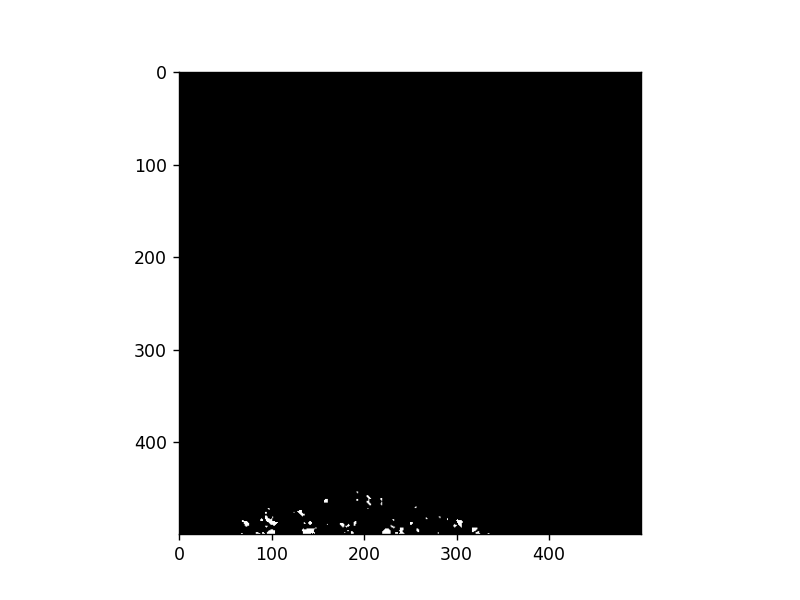

In [40]:
plt.figure()
plt.imshow(slice_1400[50], cmap = 'gray')
plt.show()

In [ ]:
# slice_1400= tifffile.imread(r'C:\Users\vdial\OneDrive - Universiteit Utrecht\Masters\Master Thesis\Methods\Segmentation\13-12-2021 Segmentation-Cropped images\Ilastik Segmentation\1400\Segmentation 15-12-21 -Stack\*.tif')
# print(slice_1400.shape)

timestep=300
plt.figure()
plt.imshow(slice_1400[timestep], cmap = 'gray')
plt.show()

Here I show an example of calculting s2 and fn for all slices and how to plot it for one time step, you can use a loop to iterate over the list and plot all of them in one plot.

In this section I import the timelog file. In order to use the values of the column  Scan# Start_time !

In [41]:
if os.name in ['nt']: #hamed
    time_path = r'D:\Hamed\Segmentated-Cropped images 600,1400/timeseries.log'
    tl=pd.read_fwf(time_path) 
else: # you
    time_path = r'C:\Users\vdial\OneDrive\Desktop\Master thesis data\Evangelos/timeseries.log'
    tl=pd.read_fwf(time_path)


In [10]:
# tl=pd.read_fwf(r'C:\Users\vdial\OneDrive\Desktop\Master thesis data\Evangelos/timeseries.log')  
# timelog=tl.copy()

# timelog["Start_time"] = pd.to_datetime(timelog["Start_time"]) #change str to datetime.time data

# timestep=timelog['Scan#'].tolist()


In [42]:
tl

Dataset  Scan#           Start_time             End_time  Duration  \
0    KBr012_0001      1  2021-06-07T00:54:13  2021-06-07T00:54:40        26   
1    KBr012_0002      2  2021-06-07T00:55:14  2021-06-07T00:55:30        16   
2    KBr012_0003      3  2021-06-07T00:56:15  2021-06-07T00:56:32        17   
3    KBr012_0004      4  2021-06-07T00:57:16  2021-06-07T00:57:32        16   
4    KBr012_0005      5  2021-06-07T00:58:16  2021-06-07T00:58:32        16   
..           ...    ...                  ...                  ...       ...   
302  KBr012_0306    306  2021-06-07T06:21:14  2021-06-07T06:21:31        17   
303  KBr012_0307    307  2021-06-07T06:22:15  2021-06-07T06:22:30        15   
304  KBr012_0308    308  2021-06-07T06:23:15  2021-06-07T06:23:31        16   
305  KBr012_0309    309  2021-06-07T06:24:16  2021-06-07T06:24:32        16   
306  KBr012_0310    310  2021-06-07T06:25:16  2021-06-07T06:25:33        17   

     Temperature  
0        -562.47  
1        -562.47  
2        -562.47  
3        -562.47  
4        -562.47  
..           ...  
302      -562.47  
303      -562.47  
304      -562.47  
305      -562.47  
306      -562.47  

[307 rows x 6 columns]

In [43]:
 # this makes the times in seconds 
times=[pd.Timestamp(t).timestamp() for t in tl['End_time'].values]
# then we can subtract from initial time
delta_time = [s - times[0] for s in times] # in seconds
#delta_time show the time after begining of experiment in seconds

In [44]:
tl['Reaction_time'] =  delta_time.copy()

In [45]:
tl

Dataset  Scan#           Start_time             End_time  Duration  \
0    KBr012_0001      1  2021-06-07T00:54:13  2021-06-07T00:54:40        26   
1    KBr012_0002      2  2021-06-07T00:55:14  2021-06-07T00:55:30        16   
2    KBr012_0003      3  2021-06-07T00:56:15  2021-06-07T00:56:32        17   
3    KBr012_0004      4  2021-06-07T00:57:16  2021-06-07T00:57:32        16   
4    KBr012_0005      5  2021-06-07T00:58:16  2021-06-07T00:58:32        16   
..           ...    ...                  ...                  ...       ...   
302  KBr012_0306    306  2021-06-07T06:21:14  2021-06-07T06:21:31        17   
303  KBr012_0307    307  2021-06-07T06:22:15  2021-06-07T06:22:30        15   
304  KBr012_0308    308  2021-06-07T06:23:15  2021-06-07T06:23:31        16   
305  KBr012_0309    309  2021-06-07T06:24:16  2021-06-07T06:24:32        16   
306  KBr012_0310    310  2021-06-07T06:25:16  2021-06-07T06:25:33        17   

     Temperature  Reaction_time  
0        -562.47            0.0  
1        -562.47           50.0  
2        -562.47          112.0  
3        -562.47          172.0  
4        -562.47          232.0  
..           ...            ...  
302      -562.47        19611.0  
303      -562.47        19670.0  
304      -562.47        19731.0  
305      -562.47        19792.0  
306      -562.47        19853.0  

[307 rows x 7 columns]

# Two-point correlations

In [46]:
slice_1400.shape

(307, 500, 500)

In [15]:
s2_list, fn_list, _ = calculate_smd_list(slice_1400)

  0%|                                                                                          | 0/307 [00:00<?, ?it/s]C:\Users\David\AppData\Local\Temp\ipykernel_25364\1781317299.py:23: RuntimeWarning: invalid value encountered in true_divide
  f_average = (S2_average - S2_average[0]**2)/S2_average[0]/(1 - S2_average[0])
100%|████████████████████████████████████████████████████████████████████████████████| 307/307 [02:04<00:00,  2.46it/s]


In [16]:
print(f"Number of s2 curve = {len(s2_list)}")
print(f"Size of each curve = {s2_list[0].shape}") # this size equals Nr, you don't need to define Nr_list

Number of s2 curve = 307
Size of each curve = (250,)


In [54]:
s2_list

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

In [47]:
np.arange(0, 306, 12).size

26

In [48]:
time_steps = np.arange(140, 306, 20)
time_steps

array([140, 160, 180, 200, 220, 240, 260, 280, 300])

In [49]:
tl

Dataset  Scan#           Start_time             End_time  Duration  \
0    KBr012_0001      1  2021-06-07T00:54:13  2021-06-07T00:54:40        26   
1    KBr012_0002      2  2021-06-07T00:55:14  2021-06-07T00:55:30        16   
2    KBr012_0003      3  2021-06-07T00:56:15  2021-06-07T00:56:32        17   
3    KBr012_0004      4  2021-06-07T00:57:16  2021-06-07T00:57:32        16   
4    KBr012_0005      5  2021-06-07T00:58:16  2021-06-07T00:58:32        16   
..           ...    ...                  ...                  ...       ...   
302  KBr012_0306    306  2021-06-07T06:21:14  2021-06-07T06:21:31        17   
303  KBr012_0307    307  2021-06-07T06:22:15  2021-06-07T06:22:30        15   
304  KBr012_0308    308  2021-06-07T06:23:15  2021-06-07T06:23:31        16   
305  KBr012_0309    309  2021-06-07T06:24:16  2021-06-07T06:24:32        16   
306  KBr012_0310    310  2021-06-07T06:25:16  2021-06-07T06:25:33        17   

     Temperature  Reaction_time  
0        -562.47            0.0  
1        -562.47           50.0  
2        -562.47          112.0  
3        -562.47          172.0  
4        -562.47          232.0  
..           ...            ...  
302      -562.47        19611.0  
303      -562.47        19670.0  
304      -562.47        19731.0  
305      -562.47        19792.0  
306      -562.47        19853.0  

[307 rows x 7 columns]

In [50]:
tl.loc[time_steps, 'Reaction_time'].values

array([ 9798., 11008., 12223., 13431., 14643., 15854., 17065., 18275.,
       19489.])

In [53]:
conversion = datetime.timedelta(seconds = 19853)
str(conversion)

'5:30:53'

In [54]:
# reaction_times_converted = {}
reaction_times_converted = []
for step in time_steps:
    reaction_time = tl.loc[step, 'Reaction_time']
    conversion = datetime.timedelta(seconds = reaction_time)
    reaction_times_converted.append(str(conversion))
reaction_times_converted

['2:43:18',
 '3:03:28',
 '3:23:43',
 '3:43:51',
 '4:04:03',
 '4:24:14',
 '4:44:25',
 '5:04:35',
 '5:24:49']

<IPython.core.display.Javascript object>


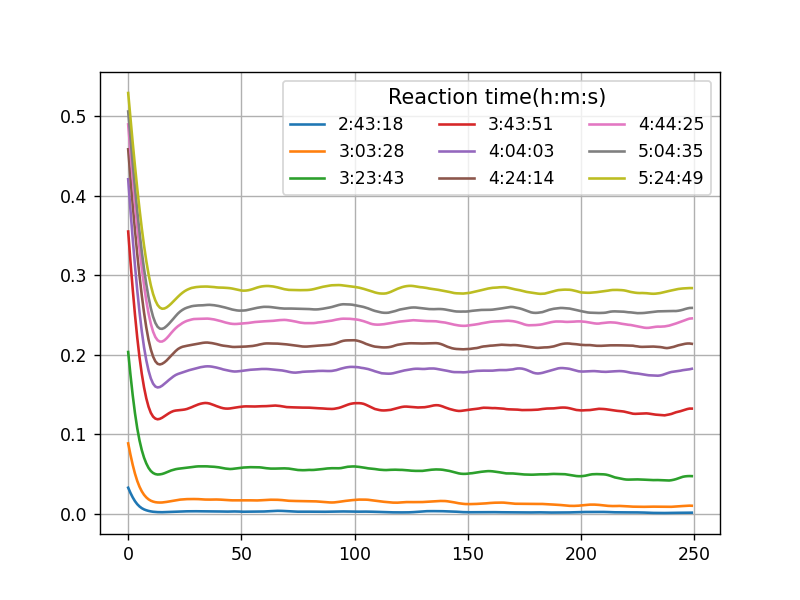

0 140
1 160
2 180
3 200
4 220
5 240
6 260
7 280
8 300


In [23]:
plt.figure()
for idx, time in enumerate(time_steps):
    print(idx, time)
    plt.plot(range(0, 250), s2_list[time], label = reaction_times_converted[idx])

plt.grid()
plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', ncol= 3)
plt.show()
#plt.savefig("TPCF_1400_s2_lines_timesteps_180,307,30.png",bbox_inches='tight')

# polytopes

In [20]:
# n_sample: image size
par={'name':'polytopes','begx': 0, 'begy': 0, 'nsamp': 500, 'edge_buffer': 0,
    'equalisation': False, 'equal_method': 'adaptive', 'stretch_percentile': 2,
    'clip_limit': 0.03, 'tvdnoise': False, 'tv_weight': 0.15, 'tv_eps': 2e-04,
    'median_filter': False, 'median_filter_length': 3,
    'thresholding_method': 'manual', 'thresholding_weight': 0.85, 'nbins': 256,
    'make_figs': False, 'fig_res': 400, 'fig_path':'./Plots/'}

In [21]:
cpathPn= r'C:\Users\David\PyMMat-master\Cpp_source\Polytope/'
runtimePn =r'C:\Users\David\PyMMat-master\runtime/'
outputPn = r'C:\Users\David\PyMMat-master\runtime\output/'

In [203]:
df_s2, df_fn = calculate_polytopes(slice_1400, output_path= outputPn, polytope = 's2')
# df_p3h, df_fn_p3h = calculate_polytopes(slice_1400, output_path= outputPn, polytope = 'p3h')
# df_p3v, df_fn_p3v = calculate_polytopes(slice_1400, output_path= outputPn, polytope = 'p3v')
# df_p4, df_fn_p4 = calculate_polytopes(slice_1400, output_path= outputPn, polytope = 'p4')
# df_p6, df_fn_p6 = calculate_polytopes(slice_1400, output_path= outputPn, polytope = 'p6')
# df_L, df_fn_L = calculate_polytopes(slice_1400, output_path= outputPn, polytope = 'L')

In [217]:
output_path = r'D:\Hamed\Segmentated-Cropped images 600,1400\Segmentation-Cropped 600-1400\1400\Polytopes_vs_time\pickles/'

##------------------------------------------------loading files--------------------------------------------
# df_s2 = joblib.dump(output_path + 's2.pkl')
# df_p3h = joblib.load(output_path + 'p3h.pkl')
# df_p3v = joblib.load(output_path + 'p3v.pkl')
# df_p4 = joblib.load(output_path + 'p4.pkl')
# df_p6 = joblib.load(output_path + 'p6.pkl')
# df_fn_L = joblib.load(output_path + 'Lineal.pkl')

# ##Pn 
# df_fn = joblib.dump(output_path + 'f2.pkl')
# df_fn_p3h = joblib.load(output_path + 'fn_p3h.pkl')
# df_fn_p3v = joblib.load(output_path + 'fn_p3v.pkl')
# df_fn_p4 = joblib.load(output_path + 'fn_p4.pkl')
# df_fn_p6 = joblib.load(output_path + 'fn_p3v.pkl')
# df_fn_L = joblib.load(output_path + 'fn_Lineal.pkl')


# ##------------------------------------------------pickling files--------------------------------------------
# ##Pn 
# joblib.dump(df_s2, output_path + 's2.pkl')
# joblib.dump(df_p3h, output_path + 'p3h.pkl')
# joblib.dump(df_p3v, output_path + 'p3v.pkl')
# joblib.dump(df_p4, output_path + 'p4.pkl')
# joblib.dump(df_p6, output_path + 'p6.pkl')
# joblib.dump(df_fn_L, output_path + 'Lineal.pkl')

# ##Fn 
# joblib.dump(df_fn, output_path + 'f2.pkl')
# joblib.dump(df_fn_p3h, output_path + 'fn_p3h.pkl')
# joblib.dump(df_fn_p3v, output_path + 'fn_p3v.pkl')
# joblib.dump(df_fn_p4, output_path + 'fn_p4.pkl')
# joblib.dump(df_fn_p6, output_path + 'fn_p3v.pkl')
# joblib.dump(df_fn_L, output_path + 'fn_Lineal.pkl')

['D:\\Hamed\\Segmentated-Cropped images 600,1400\\Segmentation-Cropped 600-1400\\1400\\Polytopes_vs_time\\pickles/f2.pkl']

## Pn curves

In [ ]:
# def convert_reaction_time(start_step, time_steps):
#     """get time from timelog file (already converted to dataframe)
#     start_step: first step you want to plot curves.
#     step=50 --> ~ 1hour
#     step 100 --> ~ 2h
#     step 150 --> ~ 3h
#     step 200 --> ~ 4h
#     time_steps: minutes between scans
#     Note that in experiment 11 the time between scans is about 1 minute.
#     except for some times that there's been a stop in scanning"""
#     for step in np.arange(start_step, 307, 20):
        

In [234]:
tl

Dataset  Scan#           Start_time             End_time  Duration  \
0    KBr012_0001      1  2021-06-07T00:54:13  2021-06-07T00:54:40        26   
1    KBr012_0002      2  2021-06-07T00:55:14  2021-06-07T00:55:30        16   
2    KBr012_0003      3  2021-06-07T00:56:15  2021-06-07T00:56:32        17   
3    KBr012_0004      4  2021-06-07T00:57:16  2021-06-07T00:57:32        16   
4    KBr012_0005      5  2021-06-07T00:58:16  2021-06-07T00:58:32        16   
..           ...    ...                  ...                  ...       ...   
302  KBr012_0306    306  2021-06-07T06:21:14  2021-06-07T06:21:31        17   
303  KBr012_0307    307  2021-06-07T06:22:15  2021-06-07T06:22:30        15   
304  KBr012_0308    308  2021-06-07T06:23:15  2021-06-07T06:23:31        16   
305  KBr012_0309    309  2021-06-07T06:24:16  2021-06-07T06:24:32        16   
306  KBr012_0310    310  2021-06-07T06:25:16  2021-06-07T06:25:33        17   

     Temperature  Reaction_time  
0        -562.47            0.0  
1        -562.47           50.0  
2        -562.47          112.0  
3        -562.47          172.0  
4        -562.47          232.0  
..           ...            ...  
302      -562.47        19611.0  
303      -562.47        19670.0  
304      -562.47        19731.0  
305      -562.47        19792.0  
306      -562.47        19853.0  

[307 rows x 7 columns]

In [245]:
# print(time_steps)
df_s2[time_steps[1]][:, 1][0],slice_1400[time_steps[1]].sum()/slice_1400[time_steps[1]].size

(0.020207, 0.020288)

<IPython.core.display.Javascript object>


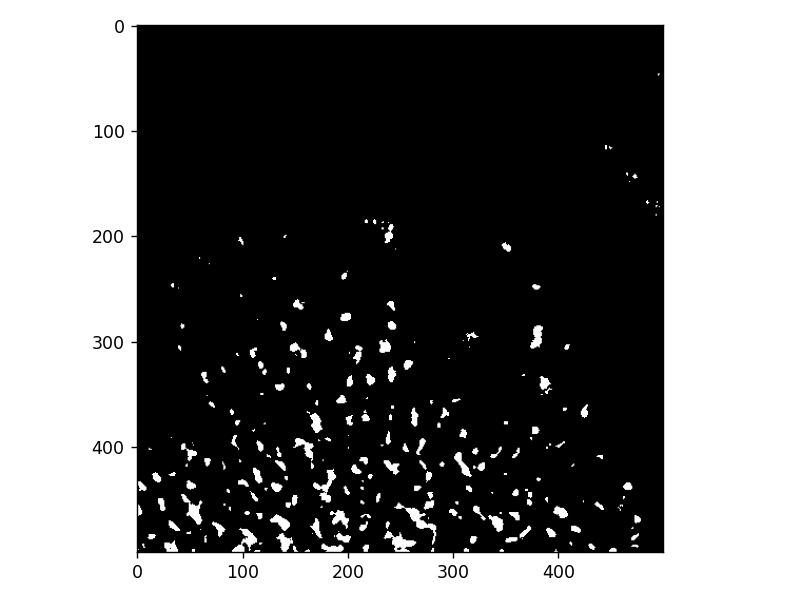

In [278]:
output_folder =  r'D:\Hamed\Segmentated-Cropped images 600,1400\Segmentation-Cropped 600-1400\1400\Polytopes_vs_time\SelectedSlices/'
fig_format = 'png'
plt.figure()
plt.imshow(slice_1400[140], cmap = 'gray')
# plt.title(f'Reactin time:{reaction_times_converted[idx]}')
plt.tight_layout()
plt.savefig(output_folder + 'slice1400_isolatedPores' + '.' + fig_format, format= fig_format, dpi = 1500)
plt.show()

In [271]:
time_steps

array([100, 125, 150, 175, 200, 225, 250, 275])

<IPython.core.display.Javascript object>


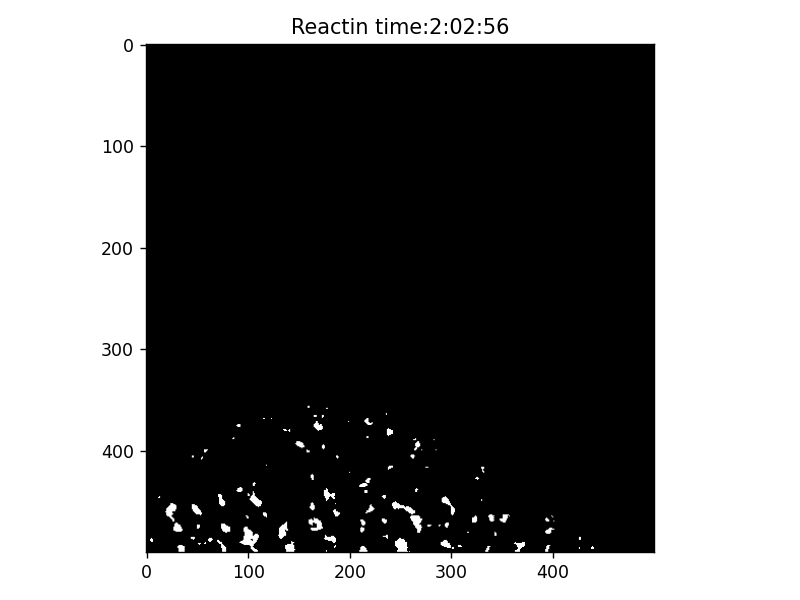

<IPython.core.display.Javascript object>


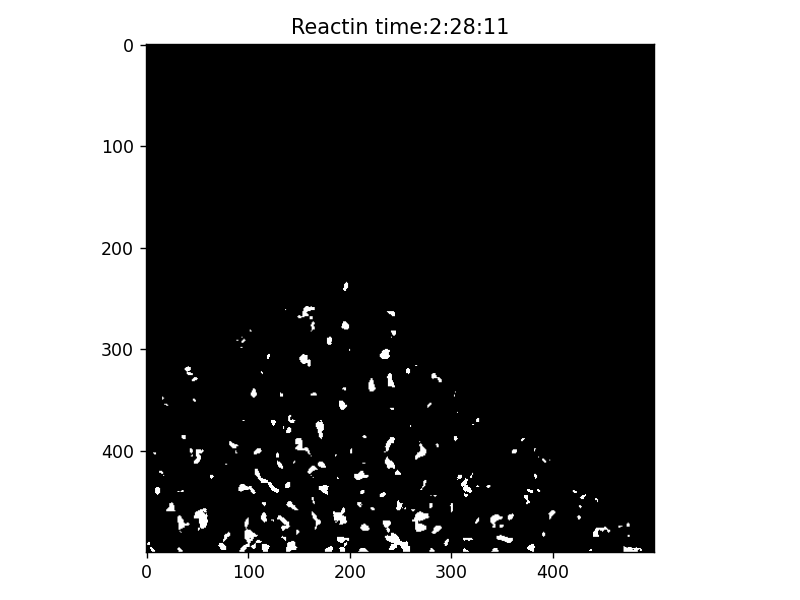

<IPython.core.display.Javascript object>


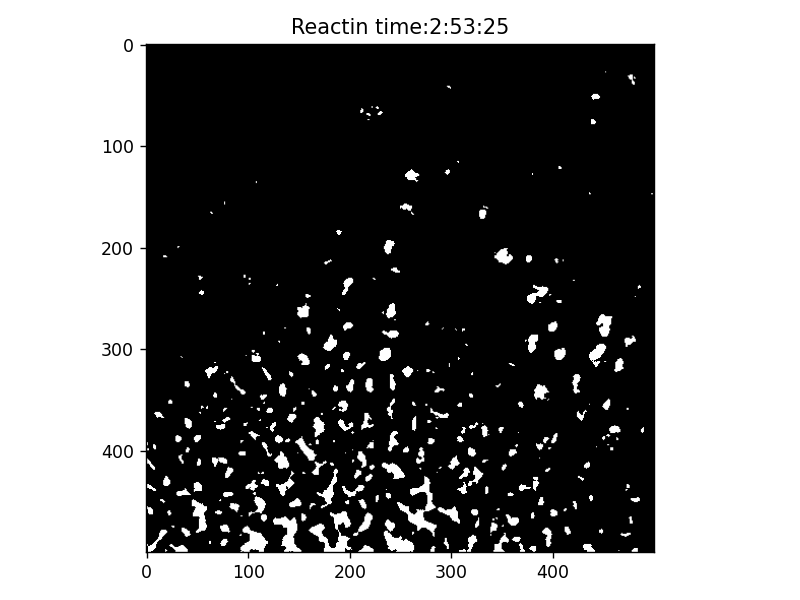

<IPython.core.display.Javascript object>


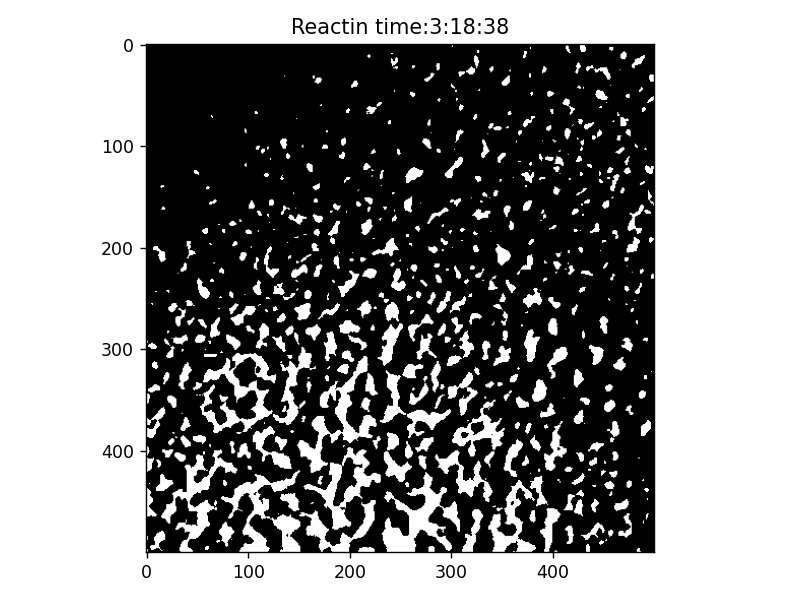

<IPython.core.display.Javascript object>


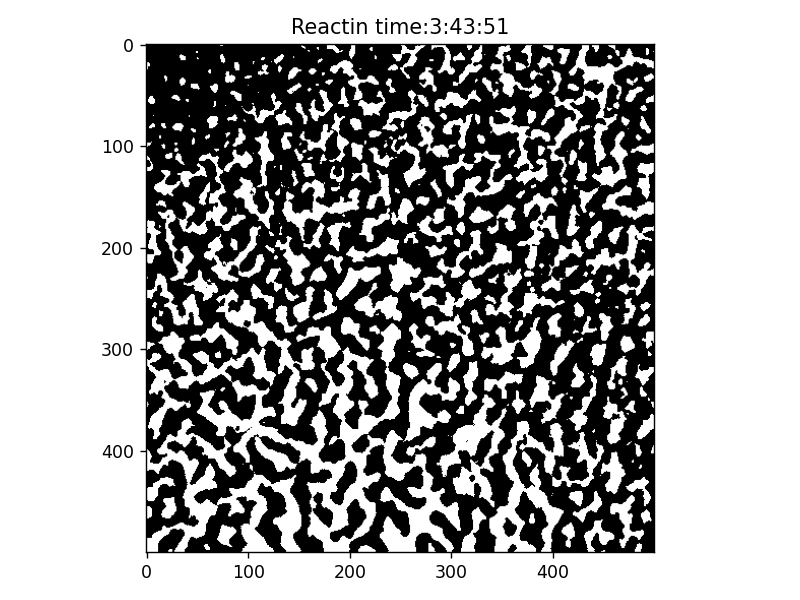

<IPython.core.display.Javascript object>


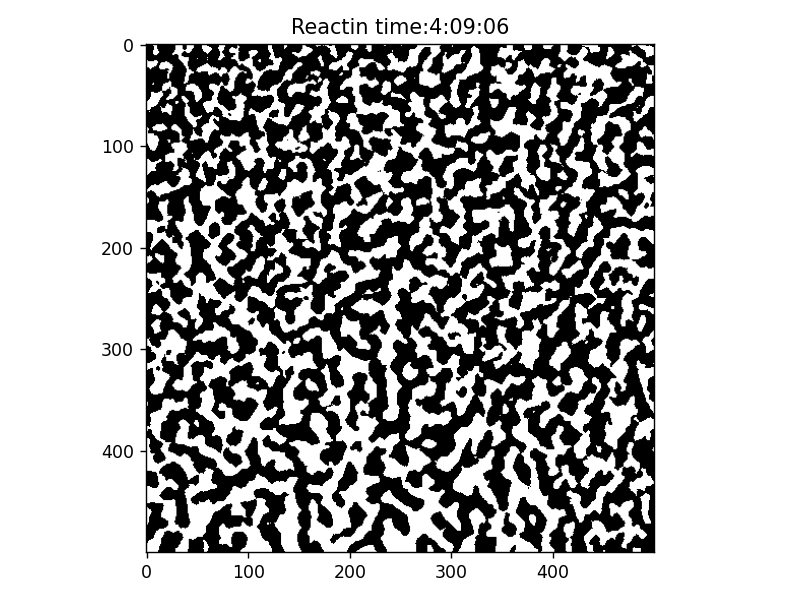

<IPython.core.display.Javascript object>


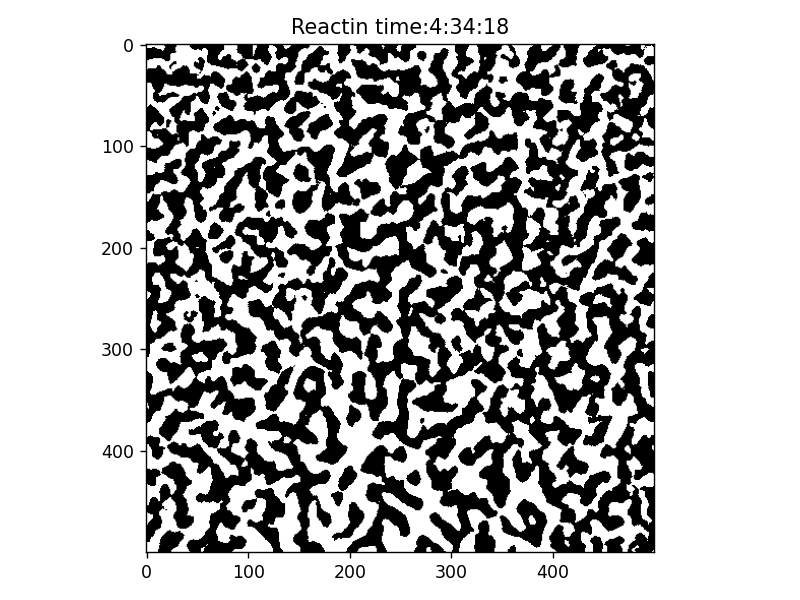

<IPython.core.display.Javascript object>


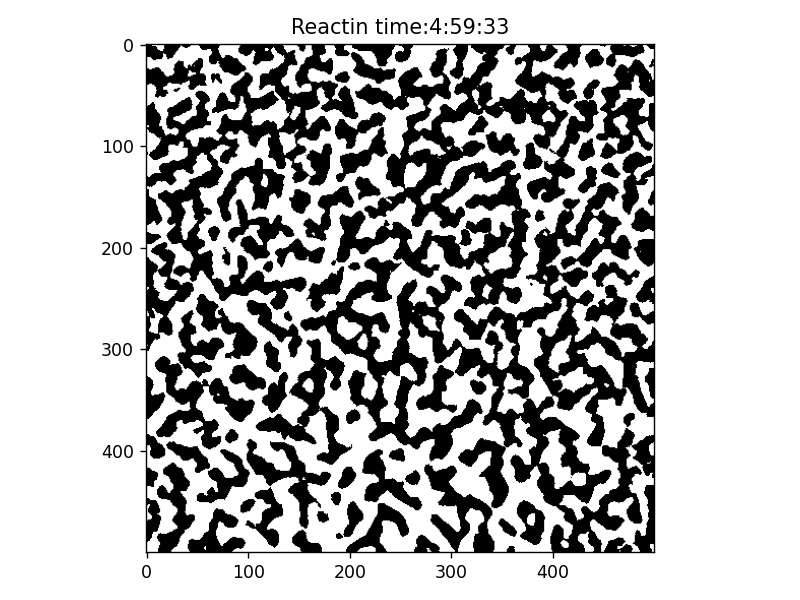

In [255]:
output_folder =  r'D:\Hamed\Segmentated-Cropped images 600,1400\Segmentation-Cropped 600-1400\1400\Polytopes_vs_time\SelectedSlices/'
fig_format = 'pdf'

# plt.figure()
# plt.imshow(slice_1400[time_steps[1]], cmap = 'gray')
# plt.tight_layout()
# plt.show()

for idx, time in enumerate(time_steps):
    plt.figure()
    plt.imshow(slice_1400[time], cmap = 'gray')
    plt.title(f'Reactin time:{reaction_times_converted[idx]}')
    plt.tight_layout()
    hour = reaction_times_converted[idx][0]
    minute =reaction_times_converted[idx][2:4]
#     plt.savefig(output_folder + f'Slice1400_{hour}h_{minute}min' + '.' + fig_format, format= fig_format, dpi = 1500)

    plt.show()
    

In [251]:
plt.close('all')

In [233]:
# reaction_times_converted = {}
time_steps =np.arange(100,300, 25)
reaction_times_converted = []
for step in time_steps:
    reaction_time = tl.loc[step, 'Reaction_time']
    conversion = datetime.timedelta(seconds = reaction_time)
    reaction_times_converted.append(str(conversion))
reaction_times_converted

['2:02:56',
 '2:28:11',
 '2:53:25',
 '3:18:38',
 '3:43:51',
 '4:09:06',
 '4:34:18',
 '4:59:33']

<IPython.core.display.Javascript object>


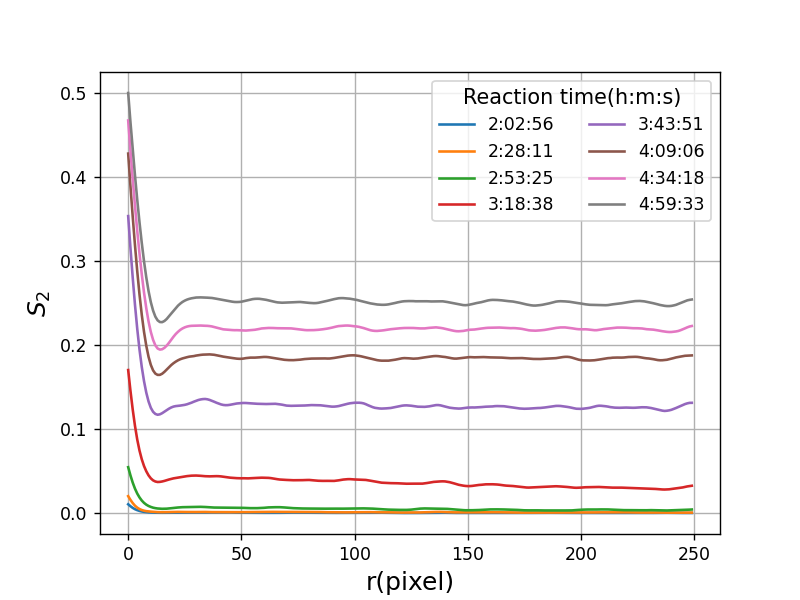

<IPython.core.display.Javascript object>


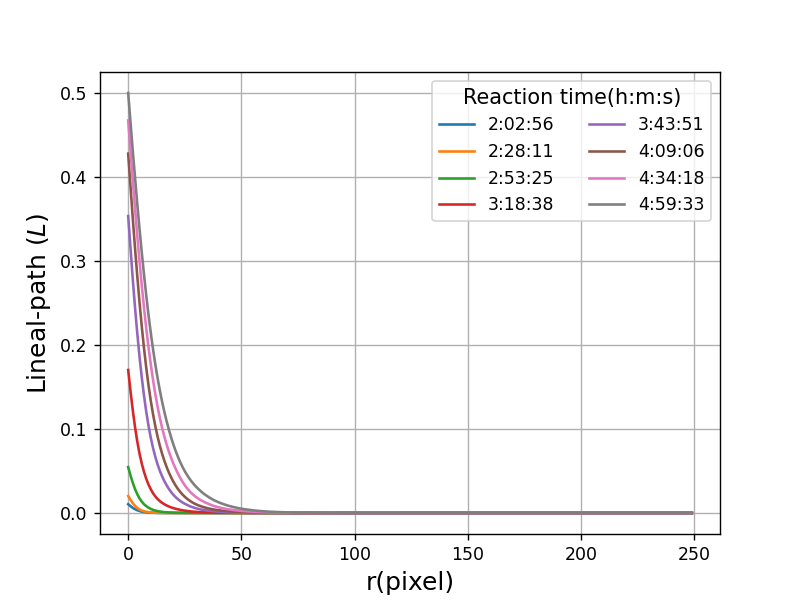

In [221]:
##--------------------------------------------------------
output_folder = r'D:\Hamed\Segmentated-Cropped images 600,1400\Segmentation-Cropped 600-1400\1400\Polytopes_vs_time\plots/'
fig_format = 'pdf'


##S2------------
plt.figure()
for idx, time in enumerate(time_steps):
#     print(idx, time)
    plt.plot(df_s2[time][:, 0], df_s2[time][:, 1], label = reaction_times_converted[idx])

plt.xlabel('r(pixel)', fontsize = 'x-large')
plt.ylabel('$S_2$', fontsize = 'x-large')
plt.grid()
plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', fontsize = 'medium', ncol= 2)
# plt.savefig(output_folder + 'pn_s2' + '.' + fig_format, format= fig_format, dpi = 1500)
plt.show()

# ##--------p3h
# plt.figure()
# for idx, time in enumerate(time_steps):
# #     print(idx, time)
#     plt.plot(df_p3h[time][:,0][::2], df_p3h[time][:,1][::2], label = reaction_times_converted[idx])

# plt.xlabel('r(pixel)', fontsize = 'x-large')
# plt.ylabel('$P_{3H}$', fontsize = 'x-large')
# plt.grid()
# plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', fontsize = 'medium', ncol= 2)
# # plt.savefig(output_folder + 'pn_p3h' + '.' + fig_format, format= fig_format, dpi = 1500)
# plt.show()

# ##--------p3v
# plt.figure()
# for idx, time in enumerate(time_steps):
# #     print(idx, time)
#     plt.plot(df_p3v[time][:,0][::2], df_p3v[time][:,1][::2], label = reaction_times_converted[idx])

# plt.xlabel('r(pixel)', fontsize = 'x-large')
# plt.ylabel('$P_{3V}$', fontsize = 'x-large')
# plt.grid()
# plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', fontsize = 'medium', ncol= 2)
# # plt.savefig(output_folder + 'pn_p3v' + '.' + fig_format, format= fig_format, dpi = 1500)

# plt.show()

# ##--------p4
# plt.figure()
# for idx, time in enumerate(time_steps):
# #     print(idx, time)
#     plt.plot(df_p4[time][:,0], df_p4[time][:,1], label = reaction_times_converted[idx])

# plt.xlabel('r(pixel)', fontsize = 'x-large')
# plt.ylabel('$P_{4}$', fontsize = 'x-large')
# plt.grid()
# plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', fontsize = 'medium', ncol= 2)
# # plt.savefig(output_folder + 'pn_p4' + '.' + fig_format, format= fig_format, dpi = 1500)

# plt.show()
# ##--------p6
# plt.figure()
# for idx, time in enumerate(time_steps):
# #     print(idx, time)
#     plt.plot(df_p6[time][:,0], df_p6[time][:,1], label = reaction_times_converted[idx])

# plt.xlabel('r(pixel)', fontsize = 'x-large')
# plt.ylabel('$P_{6}$', fontsize = 'x-large')
# plt.grid()
# plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', fontsize = 'medium', ncol= 2)
# # plt.savefig(output_folder + 'pn_p6' + '.' + fig_format, format= fig_format, dpi = 1500)
# plt.show()

##--------Lineal
plt.figure()
for idx, time in enumerate(time_steps):
#     print(idx, time)
    plt.plot(df_L[time][:,0], df_L[time][:,1], label = reaction_times_converted[idx])

plt.xlabel('r(pixel)', fontsize = 'x-large')
plt.ylabel('Lineal-path ($L$)', fontsize = 'x-large')
plt.grid()
plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', fontsize = 'medium', ncol= 2)
# plt.savefig(output_folder + 'pn_L' + '.' + fig_format, format= fig_format, dpi = 1500)
plt.show()




<span class="girk">Zooming into short range</span>

<IPython.core.display.Javascript object>


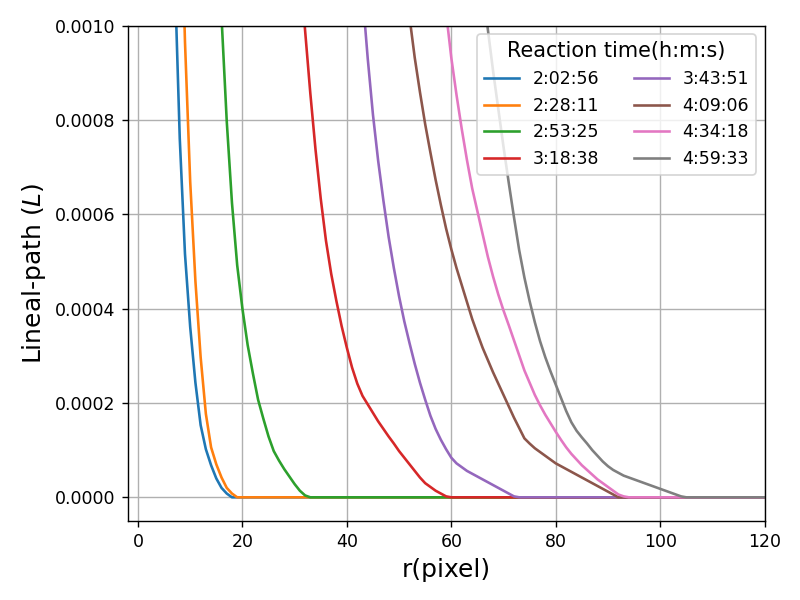

In [264]:
##--------------------------------------------------------
output_folder = r'D:\Hamed\Segmentated-Cropped images 600,1400\Segmentation-Cropped 600-1400\1400\Polytopes_vs_time\plots\zoom/'
fig_format = 'png'


# ##S2------------
# plt.figure()
# for idx, time in enumerate(time_steps):
# #     print(idx, time)
#     plt.plot(df_s2[time][:, 0], df_s2[time][:, 1], label = reaction_times_converted[idx])

# plt.xlabel('r(pixel)', fontsize = 'x-large')
# plt.ylabel('$S_2$', fontsize = 'x-large')
# plt.xlim(-5, 40)
# plt.ylim(0, 0.55)
# plt.grid()
# plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', fontsize = 'medium', ncol= 2)
# # plt.savefig(output_folder + 'pn_s2_zoom' + '.' + fig_format, format= fig_format, dpi = 1500)
# plt.show()



# ##--------p3h
# plt.figure()
# for idx, time in enumerate(time_steps):
# #     print(idx, time)
#     plt.plot(df_p3h[time][:,0][::2], df_p3h[time][:,1][::2], label = reaction_times_converted[idx])

# plt.xlabel('r(pixel)', fontsize = 'x-large')
# plt.ylabel('$P_{3H}$', fontsize = 'x-large')
# plt.xlim(-5, 40)
# plt.ylim(0, 0.55)
# plt.grid()
# plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', fontsize = 'medium', ncol= 2)
# # plt.savefig(output_folder + 'pn_p3h_zoom' + '.' + fig_format, format= fig_format, dpi = 1500)
# plt.show()

# ##--------p3v
# plt.figure()
# for idx, time in enumerate(time_steps):
# #     print(idx, time)
#     plt.plot(df_p3v[time][:,0][::2], df_p3v[time][:,1][::2], label = reaction_times_converted[idx])

# plt.xlabel('r(pixel)', fontsize = 'x-large')
# plt.ylabel('$P_{3V}$', fontsize = 'x-large')
# plt.xlim(-5, 40)
# plt.ylim(0, 0.55)
# plt.grid()
# plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', fontsize = 'medium', ncol= 2)
# # plt.savefig(output_folder + 'pn_p3v_zoom' + '.' + fig_format, format= fig_format, dpi = 1500)

# plt.show()

# ##--------p4
# plt.figure()
# for idx, time in enumerate(time_steps):
# #     print(idx, time)
#     plt.plot(df_p4[time][:,0], df_p4[time][:,1], label = reaction_times_converted[idx])

# plt.xlabel('r(pixel)', fontsize = 'x-large')
# plt.ylabel('$P_{4}$', fontsize = 'x-large')
# plt.xlim(-5, 40)
# plt.ylim(0, 0.55)
# plt.grid()
# plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', fontsize = 'medium', ncol= 2)
# # plt.savefig(output_folder + 'pn_p4_zoom' + '.' + fig_format, format= fig_format, dpi = 1500)

# plt.show()
# ##--------p6
# plt.figure()
# for idx, time in enumerate(time_steps):
# #     print(idx, time)
#     plt.plot(df_p6[time][:,0], df_p6[time][:,1], label = reaction_times_converted[idx])

# plt.xlabel('r(pixel)', fontsize = 'x-large')
# plt.ylabel('$P_{6}$', fontsize = 'x-large')
# plt.xlim(-5, 40)
# plt.ylim(0, 0.55)
# plt.grid()
# plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', fontsize = 'medium', ncol= 2)
# # plt.savefig(output_folder + 'pn_p6_zoom' + '.' + fig_format, format= fig_format, dpi = 1500)
# plt.show()

##--------Lineal
plt.figure()
for idx, time in enumerate(time_steps):
#     print(idx, time)
    plt.plot(df_L[time][:,0], df_L[time][:,1], label = reaction_times_converted[idx])

plt.xlabel('r(pixel)', fontsize = 'x-large')
plt.ylabel('Lineal-path ($L$)', fontsize = 'x-large')
plt.xlim(-2, 120)
plt.ylim(-0.00005, 0.001)
plt.grid()
plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', fontsize = 'medium', ncol= 2)
plt.tight_layout()
# plt.savefig(output_folder + 'pn_L_zoom2' + '.' + fig_format, format= fig_format, dpi = 1500)
plt.show()


## Fn

<IPython.core.display.Javascript object>


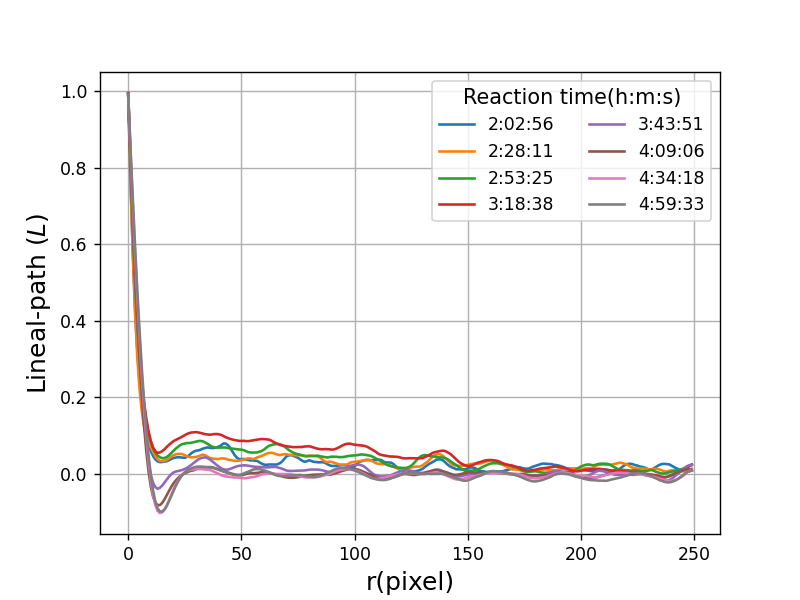

In [224]:
##--------------------------------------------------------
output_folder = r'D:\Hamed\Segmentated-Cropped images 600,1400\Segmentation-Cropped 600-1400\1400\Polytopes_vs_time\plots/'
fig_format = 'png'

# plt.figure()
# for idx, time in enumerate(time_steps):
# #     print(idx, time)
#     plt.plot(df_fn[time][:,0], df_fn[time][:,1], label = reaction_times_converted[idx])

# plt.xlabel('r(pixel)', fontsize = 'x-large')
# plt.ylabel('$F_2$', fontsize = 'x-large')
# plt.grid()
# plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', fontsize = 'medium', ncol= 2)
# plt.savefig(output_folder + 'Fn_s2' + '.' + fig_format, format= fig_format, dpi = 1500)
# plt.show()

# ##--------p3h
# plt.figure()
# for idx, time in enumerate(time_steps):
# #     print(idx, time)
#     plt.plot(df_fn_p3h[time][:,0][::2], df_fn_p3h[time][:,1][::2], label = reaction_times_converted[idx])

# plt.xlabel('r(pixel)', fontsize = 'x-large')
# plt.ylabel('$F_{3H}$', fontsize = 'x-large')
# plt.grid()
# plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', fontsize = 'medium', ncol= 2)
# # plt.savefig(output_folder + 'Fn_p3h' + '.' + fig_format, format= fig_format, dpi = 1500)
# plt.show()

# ##--------p3v
# plt.figure()
# for idx, time in enumerate(time_steps):
# #     print(idx, time)
#     plt.plot(df_fn_p3v[time][:,0][::2], df_fn_p3v[time][:,1][::2], label = reaction_times_converted[idx])

# plt.xlabel('r(pixel)', fontsize = 'x-large')
# plt.ylabel('$F_{3V}$', fontsize = 'x-large')
# plt.grid()
# plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', fontsize = 'medium', ncol= 2)
# # plt.savefig(output_folder + 'Fn_p3v' + '.' + fig_format, format= fig_format, dpi = 1500)

# plt.show()

# ##--------p4
# plt.figure()
# for idx, time in enumerate(time_steps):
# #     print(idx, time)
#     plt.plot(df_fn_p4[time][:,0], df_fn_p4[time][:,1], label = reaction_times_converted[idx])

# plt.xlabel('r(pixel)', fontsize = 'x-large')
# plt.ylabel('$F_{4}$', fontsize = 'x-large')
# plt.grid()
# plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', fontsize = 'medium', ncol= 2)
# # plt.savefig(output_folder + 'Fn_p4' + '.' + fig_format, format= fig_format, dpi = 1500)

# plt.show()
##--------p6
# plt.figure()
# for idx, time in enumerate(time_steps):
# #     print(idx, time)
#     plt.plot(df_fn_p6[time][:,0], df_fn_p6[time][:,1], label = reaction_times_converted[idx])

# plt.xlabel('r(pixel)', fontsize = 'x-large')
# plt.ylabel('$F_{6}$', fontsize = 'x-large')
# plt.grid()
# plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', fontsize = 'medium', ncol= 2)
# # plt.savefig(output_folder + 'Fn_p6' + '.' + fig_format, format= fig_format, dpi = 1500)
# plt.show()

##--------Lineal
plt.figure()
for idx, time in enumerate(time_steps):
#     print(idx, time)
    plt.plot(df_fn_L[time][:,0], df_fn_L[time][:,1], label = reaction_times_converted[idx])

plt.xlabel('r(pixel)', fontsize = 'x-large')
plt.ylabel('Lineal-path ($L$)', fontsize = 'x-large')
plt.grid()
plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', fontsize = 'medium', ncol= 2)
# plt.savefig(output_folder + 'Fn_L' + '.' + fig_format, format= fig_format, dpi = 1500)
plt.show()


<span class="girk">Zooming into short range</span>

<IPython.core.display.Javascript object>


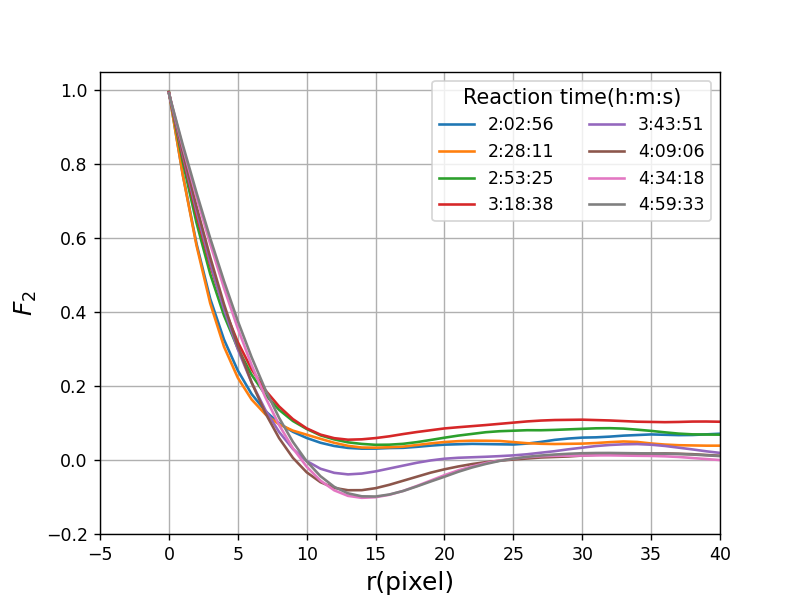

<IPython.core.display.Javascript object>


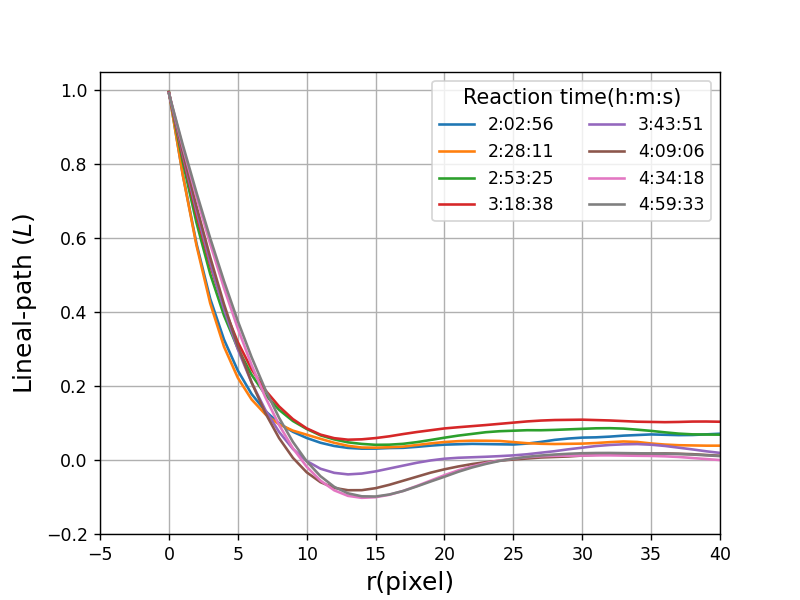

In [225]:
##--------------------------------------------------------
output_folder = r'D:\Hamed\Segmentated-Cropped images 600,1400\Segmentation-Cropped 600-1400\1400\Polytopes_vs_time\plots\zoom/'
fig_format = 'png'

plt.figure()
for idx, time in enumerate(time_steps):
#     print(idx, time)
    plt.plot(df_fn[time][:,0], df_fn[time][:,1], label = reaction_times_converted[idx])

plt.xlabel('r(pixel)', fontsize = 'x-large')
plt.ylabel('$F_2$', fontsize = 'x-large')
plt.xlim(-5, 40)
plt.ylim(-0.2, 1.05)
plt.grid()
plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', fontsize = 'medium', ncol= 2)
# plt.savefig(output_folder + 'Fn_s2_zoom' + '.' + fig_format, format= fig_format, dpi = 1500)
plt.show()

# ##--------p3h
# plt.figure()
# for idx, time in enumerate(time_steps):
# #     print(idx, time)
#     plt.plot(df_fn_p3h[time][:,0][::2], df_fn_p3h[time][:,1][::2], label = reaction_times_converted[idx])

# plt.xlabel('r(pixel)', fontsize = 'x-large')
# plt.ylabel('$F_{3H}$', fontsize = 'x-large')
# plt.xlim(-5, 40)
# plt.ylim(-0.2, 1.05)
# plt.grid()
# plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', fontsize = 'medium', ncol= 2)
# # plt.savefig(output_folder + 'Fn_p3h_zoom' + '.' + fig_format, format= fig_format, dpi = 1500)
# plt.show()

# ##--------p3v
# plt.figure()
# for idx, time in enumerate(time_steps):
# #     print(idx, time)
#     plt.plot(df_fn_p3v[time][:,0][::2], df_fn_p3v[time][:,1][::2], label = reaction_times_converted[idx])

# plt.xlabel('r(pixel)', fontsize = 'x-large')
# plt.ylabel('$F_{3V}$', fontsize = 'x-large')
# plt.xlim(-5, 40)
# plt.ylim(-0.1, 1.05)
# plt.grid()
# plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', fontsize = 'medium', ncol= 2)
# # plt.savefig(output_folder + 'Fn_p3v_zoom' + '.' + fig_format, format= fig_format, dpi = 1500)

# plt.show()

# ##--------p4
# plt.figure()
# for idx, time in enumerate(time_steps):
# #     print(idx, time)
#     plt.plot(df_fn_p4[time][:,0], df_fn_p4[time][:,1], label = reaction_times_converted[idx])

# plt.xlabel('r(pixel)', fontsize = 'x-large')
# plt.ylabel('$F_{4}$', fontsize = 'x-large')
# plt.xlim(-5, 40)
# plt.ylim(-0.1, 1.05)
# plt.grid()
# plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', fontsize = 'medium', ncol= 2)
# # plt.savefig(output_folder + 'Fn_p4_zoom' + '.' + fig_format, format= fig_format, dpi = 1500)

# plt.show()
# ##--------p6
# plt.figure()
# for idx, time in enumerate(time_steps):
# #     print(idx, time)
#     plt.plot(df_fn_p6[time][:,0], df_fn_p6[time][:,1], label = reaction_times_converted[idx])

# plt.xlabel('r(pixel)', fontsize = 'x-large')
# plt.ylabel('$F_{6}$', fontsize = 'x-large')
# plt.xlim(-5, 40)
# plt.ylim(-0.1, 1.05)
# plt.grid()
# plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', fontsize = 'medium', ncol= 2)
# # plt.savefig(output_folder + 'Fn_p6_zoom' + '.' + fig_format, format= fig_format, dpi = 1500)
# plt.show()

##--------Lineal
plt.figure()
for idx, time in enumerate(time_steps):
#     print(idx, time)
    plt.plot(df_fn_L[time][:,0], df_fn_L[time][:,1], label = reaction_times_converted[idx])

plt.xlabel('r(pixel)', fontsize = 'x-large')
plt.ylabel('Lineal-path ($L$)', fontsize = 'x-large')
plt.xlim(-5, 40)
plt.ylim(-0.2, 1.05)
plt.grid()
plt.legend(title = 'Reaction time(h:m:s)',title_fontsize= 'large', fontsize = 'medium', ncol= 2)
# plt.savefig(output_folder + 'Fn_L_zoom' + '.' + fig_format, format= fig_format, dpi = 1500)
plt.show()


## All polytopes

<IPython.core.display.Javascript object>


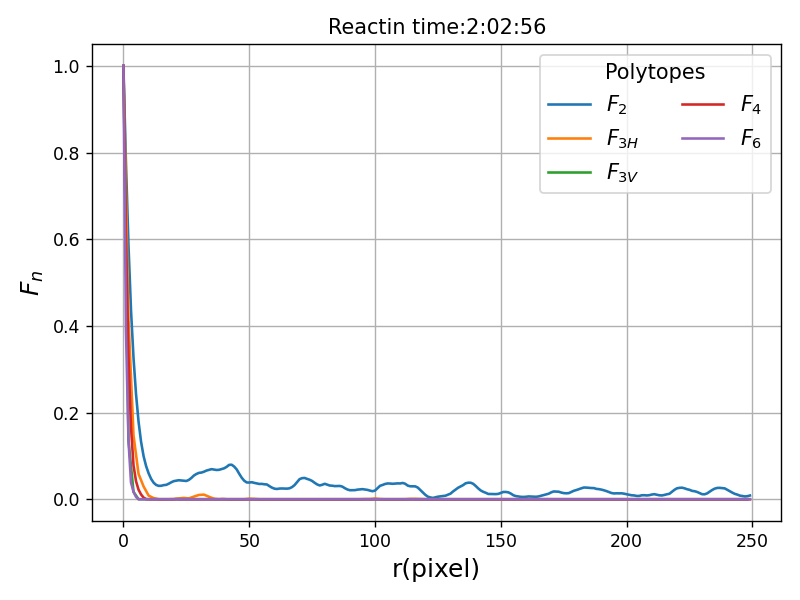

<IPython.core.display.Javascript object>


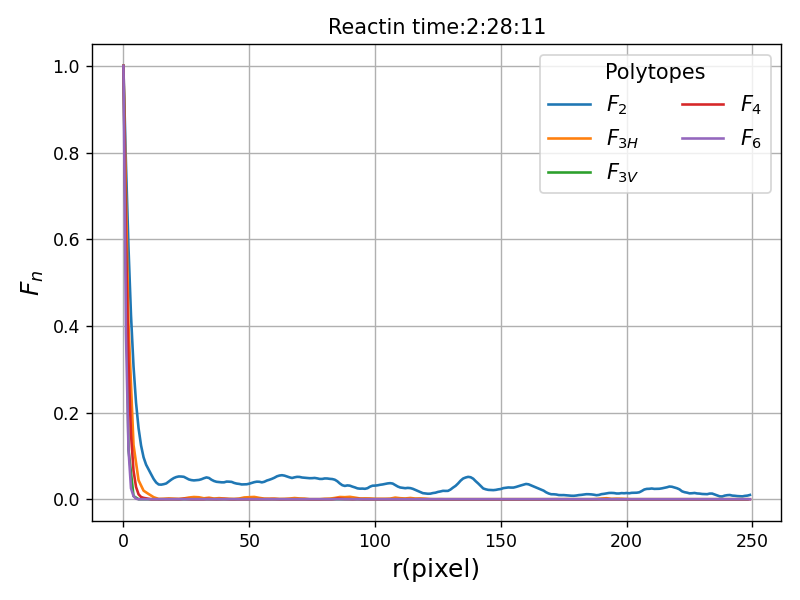

<IPython.core.display.Javascript object>


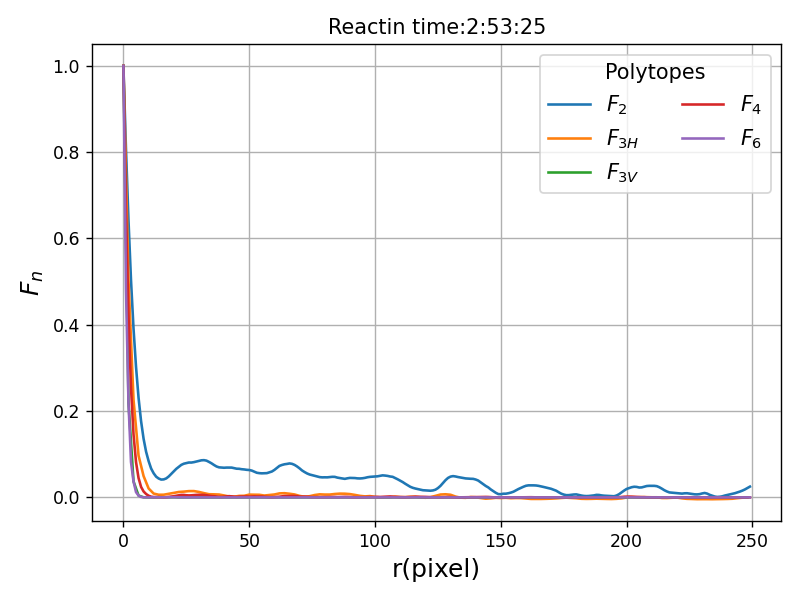

<IPython.core.display.Javascript object>


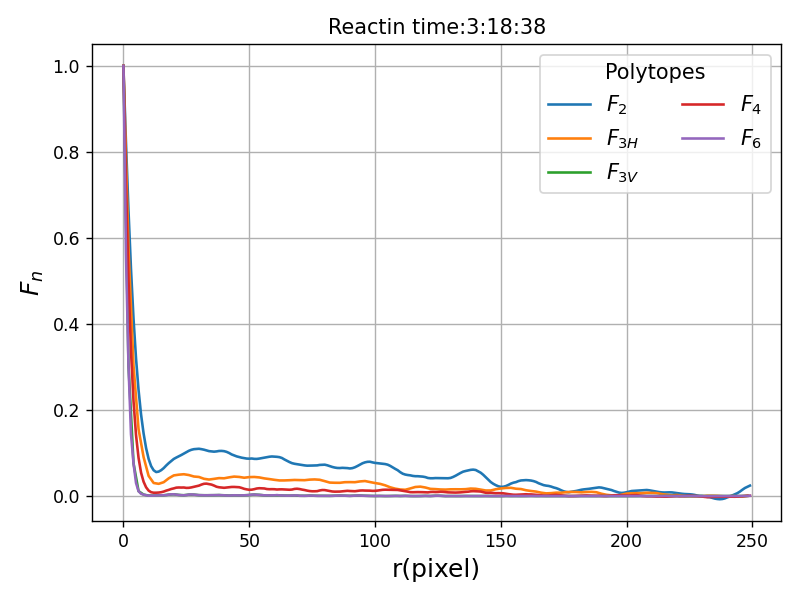

<IPython.core.display.Javascript object>


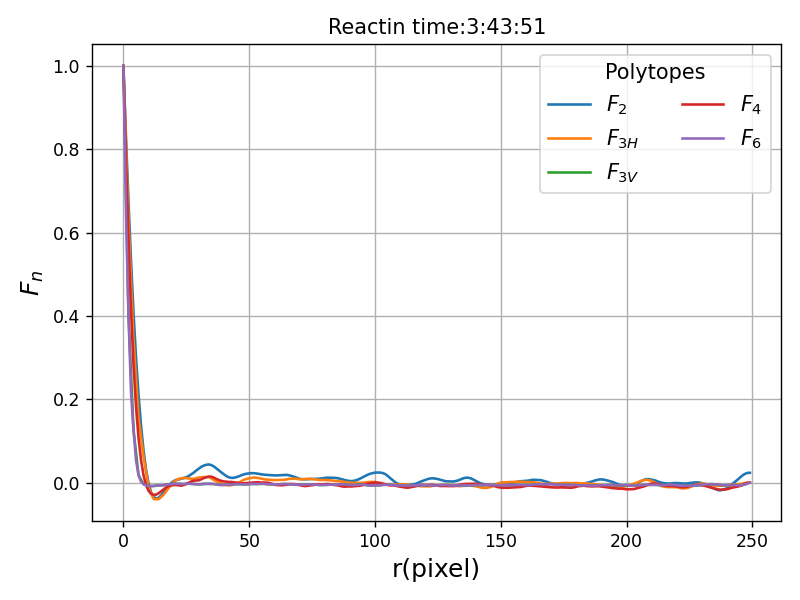

<IPython.core.display.Javascript object>


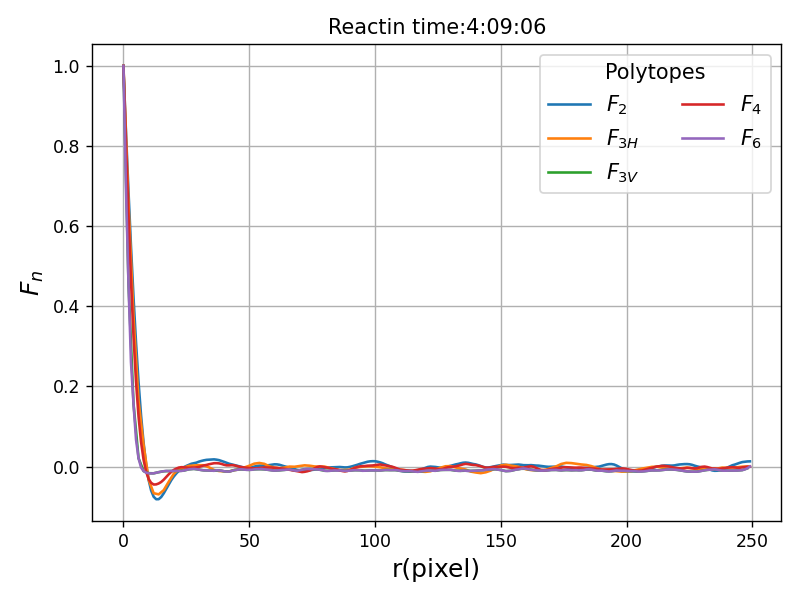

<IPython.core.display.Javascript object>


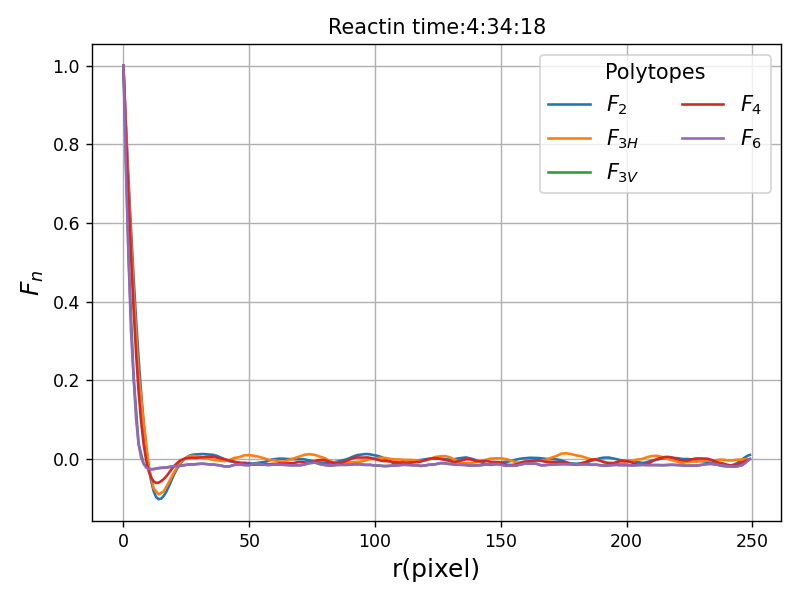

<IPython.core.display.Javascript object>


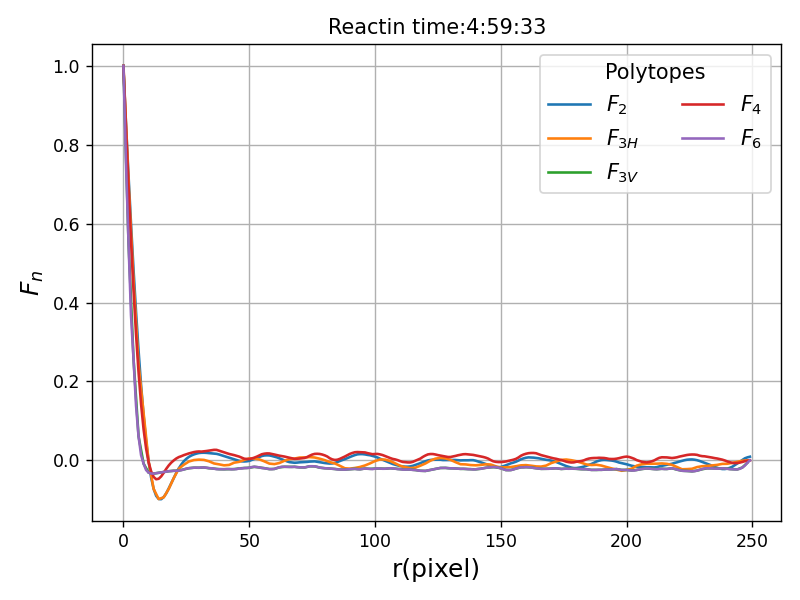

In [232]:
output_folder = r'D:\Hamed\Segmentated-Cropped images 600,1400\Segmentation-Cropped 600-1400\1400\Polytopes_vs_time\plots\AllPolytopes_time/'
fig_format = 'png'
##--------p3h

# for idx, time in enumerate(time_steps):
#     plt.figure()
#     plt.plot(df_s2[time][:,0], df_s2[time][:,1], label = '$S_2$')
#     plt.plot(df_p3h[time][:,0][::2], df_p3h[time][:,1][::2], label = '$P_{3H}$')
#     plt.plot(df_p3v[time][:,0][::2], df_p3v[time][:,1][::2], label = '$P_{3V}$')
#     plt.plot(df_p4[time][:,0], df_p4[time][:,1], label = '$P_{4}$')
#     plt.plot(df_p6[time][:,0], df_p6[time][:,1], label = '$P_{6}$')
# #     plt.plot(df_L[time][:,0], df_L[time][:,1], label = '$L$')

#     plt.xlabel('r(pixel)', fontsize = 'x-large')
#     plt.ylabel('$P_{n}$', fontsize = 'x-large')
#     plt.grid()
#     plt.legend(title = 'Polytopes',title_fontsize= 'large', fontsize = 'large', ncol= 2)
#     plt.title(f'Reactin time:{reaction_times_converted[idx]}')
#     hour = reaction_times_converted[idx][0]
#     minute =reaction_times_converted[idx][2:4]
#     plt.tight_layout()
# #     plt.savefig(output_folder + f'pn_{hour}h_{minute}min' + '.' + fig_format, format= fig_format, dpi = 1500)
#     plt.show()
    
    
for idx, time in enumerate(time_steps):
    plt.figure()
    plt.plot(df_fn[time][:,0], df_fn[time][:,1], label = '$F_2$')
    plt.plot(df_fn_p3h[time][:,0][::2], df_fn_p3h[time][:,1][::2], label = '$F_{3H}$')
    plt.plot(df_fn_p3v[time][:,0][::2], df_fn_p3v[time][:,1][::2], label = '$F_{3V}$')
    plt.plot(df_fn_p4[time][:,0], df_fn_p4[time][:,1], label = '$F_{4}$')
    plt.plot(df_fn_p6[time][:,0], df_fn_p6[time][:,1], label = '$F_{6}$')
#     plt.plot(df_L[time][:,0], df_L[time][:,1], label = '$L$')

    plt.xlabel('r(pixel)', fontsize = 'x-large')
    plt.ylabel('$F_{n}$', fontsize = 'x-large')
    plt.grid()
    plt.legend(title = 'Polytopes',title_fontsize= 'large', fontsize = 'large', ncol= 2)
    plt.title(f'Reactin time:{reaction_times_converted[idx]}')
    hour = reaction_times_converted[idx][0]
    minute =reaction_times_converted[idx][2:4]
    plt.tight_layout()
#     plt.savefig(output_folder + f'Fn_{hour}h_{minute}min' + '.' + fig_format, format= fig_format, dpi = 1500)
    plt.show()

In [188]:
plt.close('all')